In [1]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path
from typing import Iterable, Optional, Dict, Union
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy import stats

In [2]:
def plot_top_genes_across_k(output_dir, name, k_range, density_threshold=0.01, top_pct=0.01,
                            xtick_step=10, base_scale=1.6):

    all_top_genes = {}
    all_gene_sets = set()
    gep_to_k = {}

    for k in k_range:
        spectra_file = f"{output_dir}/{name}.gene_spectra_score.k_{k}.dt_{str(density_threshold).replace('.', '_')}.txt"
        spectra_df = pd.read_csv(spectra_file, sep='\t', index_col=0)

        n_genes = spectra_df.shape[1]
        n_top_genes = max(1, int(n_genes * top_pct))

        for gep_name, row in spectra_df.iterrows():
            gep_id = f"k{k}_{gep_name}"
            top_genes = row.nlargest(n_top_genes).index.tolist()
            all_top_genes[gep_id] = top_genes
            all_gene_sets.update(top_genes)
            gep_to_k[gep_id] = k

    sorted_geps = sorted(all_top_genes.keys(), key=lambda x: (gep_to_k[x], x))

    binary_matrix = pd.DataFrame(0, index=sorted_geps, columns=list(all_gene_sets), dtype=int)
    for gep, genes in all_top_genes.items():
        binary_matrix.loc[gep, genes] = 1

    gene_first_appearance = {}
    for i, gep in enumerate(binary_matrix.index):
        for gene in binary_matrix.columns[binary_matrix.loc[gep] == 1].tolist():
            if gene not in gene_first_appearance:
                gene_first_appearance[gene] = i

    sorted_genes = sorted(binary_matrix.columns, key=lambda g: (gene_first_appearance.get(g, float('inf')), g))
    binary_matrix = binary_matrix[sorted_genes]

    unique_ks = sorted(set(gep_to_k.values()))
    k_palette = sns.color_palette("tab10", len(unique_ks))
    k_to_color = {k: k_palette[i] for i, k in enumerate(unique_ks)}

    n_rows = len(binary_matrix.index)
    n_cols = len(binary_matrix.columns)

    fig_height = max(16, n_rows * 0.8 * base_scale)
    fig_width = max(26, n_cols * 0.28 * base_scale)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    heatmap = sns.heatmap(
        binary_matrix,
        cmap='YlOrRd',
        cbar_kws={'label': f'Top {top_pct*100:.1f}% Genes', 'shrink': 0.5},
        xticklabels=True,
        yticklabels=True,
        ax=ax
    )

    # === 🔥 Draw dotted separator lines between K groups ===
    y_positions = []
    prev_k = gep_to_k[binary_matrix.index[0]]

    for i, gep in enumerate(binary_matrix.index):
        current_k = gep_to_k[gep]
        if current_k != prev_k:   # K change → draw separator
            y_positions.append(i)
        prev_k = current_k

    for y in y_positions:
        ax.hlines(y, xmin=0, xmax=n_cols, linestyle='dotted', linewidth=2, color="black")

    # Style y-tick labels
    for i, label in enumerate(ax.get_yticklabels()):
        label.set_color(k_to_color[gep_to_k[binary_matrix.index[i]]])
        label.set_fontweight('bold')
        label.set_fontsize(14)

    # X-label formatting
    ax.set_xticks(np.arange(0.5, n_cols, xtick_step))
    ax.set_xticklabels(binary_matrix.columns[::xtick_step], rotation=60, ha='right', fontsize=13)

    ax.set_xlabel("Genes", fontsize=18, weight='bold')
    ax.set_ylabel("GEP (K included)", fontsize=18, weight='bold')
    ax.set_title(f"Top {top_pct*100:.1f}% Genes across K values", fontsize=22, pad=24, weight='bold')

    legend_patches = [mpatches.Patch(color=k_to_color[k], label=f"K={k}") for k in unique_ks]
    ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.02, 1),
              title='K value', fontsize=14, title_fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(right=0.88)

    return fig, binary_matrix


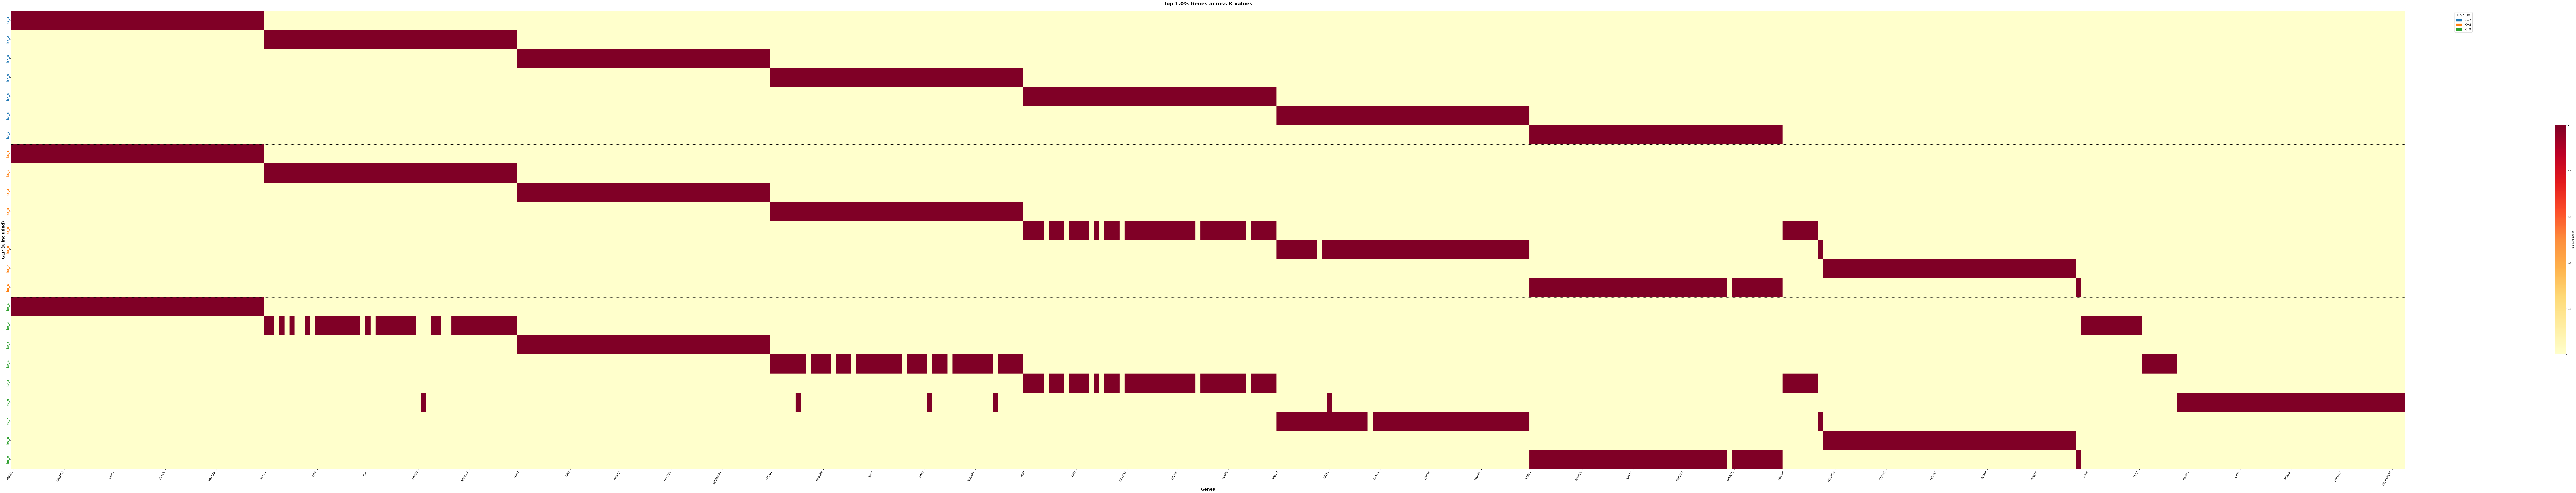

In [3]:
k_range = range(7,10)
fig, matrix = plot_top_genes_across_k(
    'all_datasets_consensus/S1_spectra_vector_subset',
    'anal_pc5_c21_S1.filtered',
    k_range
)
plt.show()

In [4]:
def plot_hierarchical_clustermap(
    output_dir: str,
    name: str,
    k_range: Optional[Iterable[int]] = None,
    density_threshold: float = 0.01,
    top_percent: float = 1.0,
    method: str = "ward",
    metric: str = "euclidean",
    cmap: str = "RdBu_r",
) -> sns.matrix.ClusterGrid:
    """
    Create a hierarchically clustered heatmap combining all K values.
    Reads cNMF gene_spectra_score files directly from disk.
    """

    # ------------------------------------------------------------------
    # 1) Load spectra files into a {K: DataFrame} dict
    # ------------------------------------------------------------------
    spectra_dict: Dict[int, pd.DataFrame] = {}

    dt_str = str(density_threshold).replace(".", "_")

    if k_range is None:
        # Auto-discover all Ks from matching files
        search_path = os.path.join(
            output_dir,
            f"{name}.gene_spectra_score.k_*.dt_{dt_str}.txt"
        )
        files = glob.glob(search_path)
        if not files:
            raise FileNotFoundError(
                f"No gene_spectra_score files found matching {search_path}"
            )

        for f in files:
            m = re.search(r"\.k_(\d+)\.", os.path.basename(f))
            if not m:
                continue
            k = int(m.group(1))
            df = pd.read_csv(f, sep="\t", index_col=0)
            spectra_dict[k] = df
            print(f"Loaded K={k}: {df.shape[0]} GEPs × {df.shape[1]} genes")
    else:
        # Use only the Ks explicitly requested in k_range
        for k in k_range:
            spectra_file = os.path.join(
                output_dir,
                f"{name}.gene_spectra_score.k_{k}.dt_{dt_str}.txt",
            )
            if not os.path.exists(spectra_file):
                raise FileNotFoundError(f"Expected file not found: {spectra_file}")
            df = pd.read_csv(spectra_file, sep="\t", index_col=0)
            spectra_dict[k] = df
            print(f"Loaded K={k}: {df.shape[0]} GEPs × {df.shape[1]} genes")

    if not spectra_dict:
        raise ValueError("No spectra matrices loaded for any K.")

    # ------------------------------------------------------------------
    # 2) Build combined matrix with K-prefixed row names
    # ------------------------------------------------------------------
    combined_dfs = []
    k_labels = []

    for k, spectra_df in sorted(spectra_dict.items()):
        df_copy = spectra_df.copy()
        # Prefix GEP row names with K value, e.g., K5_GEP1
        df_copy.index = [f"K{k}_{idx}" for idx in df_copy.index]
        combined_dfs.append(df_copy)
        k_labels.extend([k] * df_copy.shape[0])

    combined_df = pd.concat(combined_dfs, axis=0)

    # ------------------------------------------------------------------
    # 3) Determine set of top genes across all GEPs and Ks (inline logic)
    # ------------------------------------------------------------------
    all_top_genes = set()

    for k, spectra_df in spectra_dict.items():
        n_genes = spectra_df.shape[1]
        n_top = max(1, int(n_genes * top_percent / 100.0))

        for gep in spectra_df.index:
            scores = spectra_df.loc[gep].sort_values(ascending=False)
            top = scores.head(n_top)
            all_top_genes.update(top.index.tolist())

    all_top_genes = sorted(all_top_genes)

    # Subset combined matrix to only top genes
    subset_df = combined_df[all_top_genes].copy()

    # ------------------------------------------------------------------
    # 4) Row colors for K values
    # ------------------------------------------------------------------
    unique_k = sorted(spectra_dict.keys())
    k_palette = dict(zip(unique_k, sns.color_palette("husl", len(unique_k))))
    row_colors = pd.Series(k_labels, index=subset_df.index).map(k_palette)
    row_colors.name = "K value"

    # ------------------------------------------------------------------
    # 5) Figure sizing
    # ------------------------------------------------------------------
    n_genes = len(all_top_genes)
    n_geps = subset_df.shape[0]
    fig_width = max(14, n_genes * 0.10 + 4)
    fig_height = max(10, n_geps * 0.15 + 3)
    # Center colormap at 0
    vmax = np.abs(subset_df.values).max()

    # ------------------------------------------------------------------
    # 6) Make clustermap
    # ------------------------------------------------------------------
    g = sns.clustermap(
        subset_df,
        method=method,
        metric=metric,
        cmap=cmap,
        center=0,
        vmin=-vmax,
        vmax=vmax,
        row_colors=row_colors,
        figsize=(fig_width, fig_height),
        dendrogram_ratio=(0.1, 0.1),
        cbar_pos=(0.02, 0.8, 0.02, 0.12),
        xticklabels=True,
        yticklabels=True,
        linewidths=0.3,
        tree_kws={"linewidths": 1.0},
    )

    # ------------------------------------------------------------------
    # 7) Labels & legend
    # ------------------------------------------------------------------
    g.ax_heatmap.set_xlabel("Genes (hierarchically clustered)")
    g.ax_heatmap.set_ylabel("GEPs across K values (hierarchically clustered)")
    g.ax_heatmap.tick_params(axis="x", labelsize=5, rotation=90)
    g.ax_heatmap.tick_params(axis="y", labelsize=6)

    legend_handles = [Patch(facecolor=k_palette[k], label=f"K={k}") for k in unique_k]
    g.ax_heatmap.legend(
        handles=legend_handles,
        loc="upper left",
        bbox_to_anchor=(1.15, 1),
        title="K value",
        fontsize=8,
    )

    k_min, k_max = min(unique_k), max(unique_k)
    g.fig.suptitle(
        f"Combined Hierarchical Clustering: All K Values (K={k_min}-{k_max})\n"
        f"Top {top_percent}% genes ({n_genes} unique) | {n_geps} total GEPs | method={method}",
        y=1.02,
        fontsize=15,
    )

    # ------------------------------------------------------------------
    # 8) Add labels like K5_GEP1 next to the K-color sidebar
    # ------------------------------------------------------------------
    ax_row = g.ax_row_colors
    n_rows = subset_df.shape[0]

    # Widen the axis so we have room for text
    ax_row.set_xlim(0, 2)

    # g.data2d.index is the row order after clustering (top -> bottom)
    labels_ordered = g.data2d.index

    for y, label in enumerate(labels_ordered):
        ax_row.text(
            1.05,          # x position (in data coords of ax_row)
            y + 0.5,       # centered in the colored bar
            label,
            va="center",
            ha="left",
            fontsize=14,
            color="black",
            clip_on=False,
        )

    ax_row.set_xticks([])
    ax_row.set_yticks([])

    return g

Loaded K=7: 7 GEPs × 5000 genes
Loaded K=8: 8 GEPs × 5000 genes
Loaded K=9: 9 GEPs × 5000 genes


c:\Users\Sumedha\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Sumedha\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


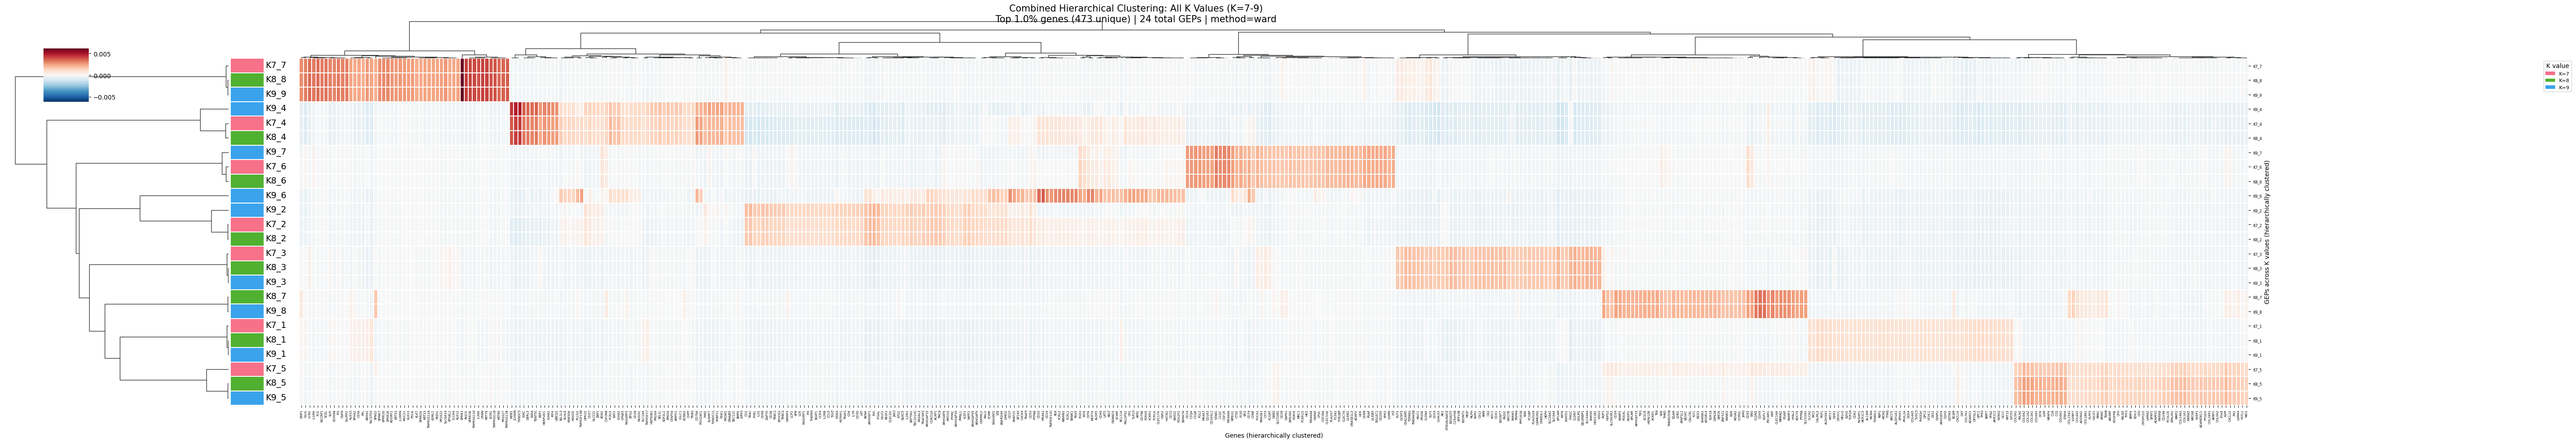

In [5]:
k_range = range(7, 10)  

g = plot_hierarchical_clustermap(
    output_dir="all_datasets_consensus/S1_spectra_vector_subset",
    name="anal_pc5_c21_S1.filtered",
    k_range=k_range,
    density_threshold=0.01,
    top_percent=1.0,
    method="ward",
    metric="euclidean",
)

plt.show()

Loaded K=12: 12 GEPs × 5000 genes
Loaded K=13: 13 GEPs × 5000 genes
Loaded K=14: 14 GEPs × 5000 genes
Loaded K=15: 15 GEPs × 5000 genes
Loaded K=16: 16 GEPs × 5000 genes
Loaded K=17: 17 GEPs × 5000 genes


c:\Users\Sumedha\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Sumedha\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


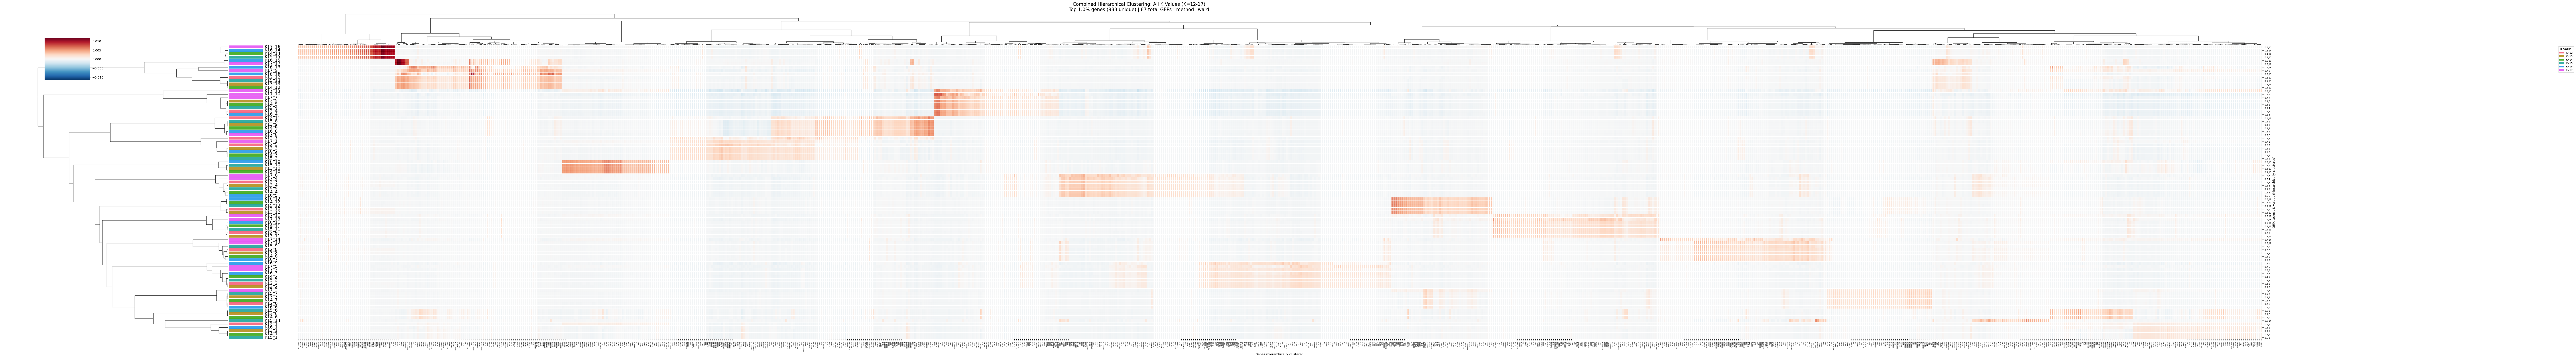

In [6]:
k_range = range(12, 18)  

g = plot_hierarchical_clustermap(
    output_dir="all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs",
    name="anal_pc5_c21_S1.filtered",
    k_range=k_range,
    density_threshold=0.01,
    top_percent=1.0,
    method="ward",
    metric="euclidean",
)

plt.show()

In [7]:
def get_top_genes_from_single_gep(spectra_file: str, gep_id: int, top_percent: float = 1.0) -> pd.DataFrame:
    
    df = pd.read_csv(spectra_file, sep="\t", index_col=0)  # use index_col=0
    
    scores = df.loc[gep_id].sort_values(ascending=False)   # use .loc with GEP label directly
    
    n_top = max(1, int(len(scores) * top_percent / 100))
    top_genes = scores.head(n_top)

    return pd.DataFrame({
        "gene": top_genes.index,
        "score": top_genes.values,
        "rank": range(1, n_top + 1),
    })

In [8]:
file = "all_datasets_consensus\S1_spectra_vector_subset/anal_pc5_c21_S1.filtered.gene_spectra_score.k_9.dt_0_01.txt"
top = get_top_genes_from_single_gep(file, gep_id=6)        # 0-based row index
print(top.head(10))

     gene     score  rank
0   MS4A1  0.003718     1
1    CD22  0.003390     2
2   WDFY4  0.003061     3
3   FCRL2  0.003011     4
4   FCRL1  0.003005     5
5  NIBAN3  0.002982     6
6   BANK1  0.002945     7
7     BLK  0.002944     8
8    PAX5  0.002943     9
9   CIITA  0.002941    10


In [13]:
uniprot_result_t10 = pd.read_csv('uniprot/S1_k9_GEP6_idmapping_model_organism_9606_AND_revie_2025_11_30.tsv', sep='\t')
uniprot_result_t10.head()

,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Gene Ontology (biological process)
0,MS4A1,P11836,reviewed,CD20_HUMAN,B-lymphocyte antigen CD20 (B-lymphocyte surfac...,MS4A1 CD20,Homo sapiens (Human),297,B cell activation [GO:0042113]; B cell differe...
1,CD22,P20273,reviewed,CD22_HUMAN,B-cell receptor CD22 (B-lymphocyte cell adhesi...,CD22 SIGLEC2,Homo sapiens (Human),847,B cell activation [GO:0042113]; cell adhesion ...
2,CIITA,P33076,reviewed,C2TA_HUMAN,MHC class II transactivator (CIITA) (EC 2.3.1....,CIITA MHC2TA,Homo sapiens (Human),1130,host-mediated suppression of symbiont invasion...
3,BLK,P51451,reviewed,BLK_HUMAN,Tyrosine-protein kinase Blk (EC 2.7.10.2) (B l...,BLK,Homo sapiens (Human),505,B cell receptor signaling pathway [GO:0050853]...
4,PAX5,Q02548,reviewed,PAX5_HUMAN,Paired box protein Pax-5 (B-cell-specific tran...,PAX5,Homo sapiens (Human),391,adult behavior [GO:0030534]; B cell differenti...


In [15]:
# Extract GO IDs and their associated description text
def extract_go_mapping(text):
    """Return list of (GO_id, description) pairs for one row."""
    # Split by semicolon to separate terms
    parts = str(text).split(";")
    pairs = []
    for p in parts:
        # Extract GO ID
        ids = re.findall(r"(GO:\d{7})", p)
        if ids:
            go_id = ids[0]
            # Description = substring before GO:xxxxxxx
            desc = p.split("[" if "[" in p else "(")[0].strip()
            pairs.append((go_id, desc))
    return pairs

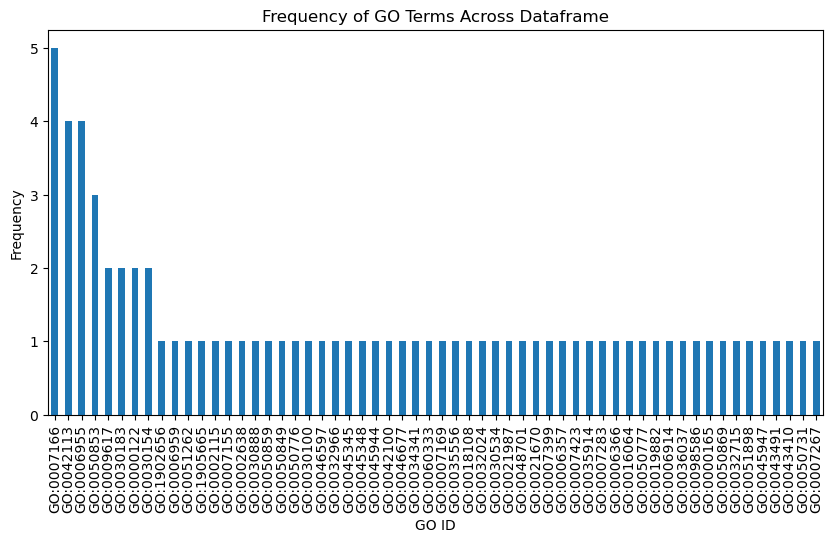

In [18]:
# Build mapping for entire dataframe
mapping = {}

for cell in uniprot_result_t10["Gene Ontology (biological process)"]:
    for go_id, desc in extract_go_mapping(cell):
        mapping[go_id] = desc  # (keeps latest if duplicated, OK for standard GO terms)

# Count frequency of each GO ID
uniprot_result_t10["GO_terms"] = uniprot_result_t10["Gene Ontology (biological process)"].apply(
    lambda x: re.findall(r"GO:\d{7}", str(x))
)
go_counts = uniprot_result_t10.explode("GO_terms")["GO_terms"].value_counts()

# --- Plot histogram ---
plt.figure(figsize=(10,5))
go_counts.plot(kind="bar")
plt.xlabel("GO ID")
plt.ylabel("Frequency")
plt.title("Frequency of GO Terms Across Dataframe")
plt.show()

In [19]:
mapping['GO:0007166']

'cell surface receptor signaling pathway'